In [4]:
import requests
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import urllib.request
import json

In [5]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'  # Windows: 'Malgun Gothic', MacOS: 'AppleGothic', Linux: 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False     # 그래프에서 마이너스 기호 깨짐 방지

In [6]:
# 네이버 API 키 설정 (환경 변수에서 불러오기)
client_id = os.getenv('NAVER_CLIENT_ID', 'YaKyDrFyIZDRfIiRAwBj')
client_secret = os.getenv('NAVER_CLIENT_SECRET', 'hknmr5WHGm')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

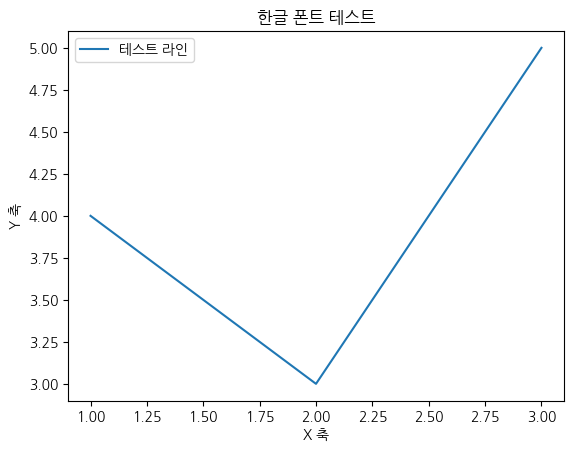

In [7]:
# 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔 고딕 폰트 경로 확인
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 설정
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 나눔고딕 설치 경로 확인
print([f.name for f in fm.fontManager.ttflist if 'Nanum' in f.name])

# 테스트 그래프
plt.plot([1, 2, 3], [4, 3, 5], label='테스트 라인')
plt.title('한글 폰트 테스트')
plt.xlabel('X 축')
plt.ylabel('Y 축')
plt.legend()
plt.show()



In [8]:
# 1단계: 업비트 API에서 데이터 가져오기
def fetch_upbit_data(market="KRW-BTC", count=200):
    url = "https://api.upbit.com/v1/candles/minutes/60"
    params = {"market": market, "count": count}
    response = requests.get(url, params=params)
    data = response.json()
    df = pd.DataFrame(data)
    df = df[["candle_date_time_kst", "trade_price"]]
    df.columns = ["date", "price"]
    df["date"] = pd.to_datetime(df["date"])
    df.sort_values(by="date", inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [9]:
# 2단계: 네이버 뉴스 API 감정 분석 데이터 가져오기
def get_news_data(client_id, client_secret, query, display=100, sort='date'):
    enc_text = urllib.parse.quote(query)
    url = f"https://openapi.naver.com/v1/search/news?query={enc_text}&display={display}&sort={sort}"
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    response = urllib.request.urlopen(request)
    rescode = response.getcode()
    if rescode == 200:
        response_body = response.read()
        response_json = json.loads(response_body)
        df = pd.DataFrame(response_json['items'])
        df = df[['pubDate', 'description']]
        df['pubDate'] = pd.to_datetime(df['pubDate'], errors='coerce')
        df.dropna(subset=['pubDate'], inplace=True)
        df.columns = ['date', 'description']
        return df
    else:
        print(f"Error Code: {rescode}")
        return pd.DataFrame()

In [10]:
# 3단계: KoBERT 모델 로드 및 감정 분석 수행
def load_sentiment_model():
    model_name = "beomi/kcbert-base"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return tokenizer, model, device

def analyze_sentiments(texts, tokenizer, model, device):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, max_length=300, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    sentiments = torch.argmax(logits, dim=-1).tolist()
    return sentiments

In [11]:
# # 4단계: 가격 데이터와 감정 분석 데이터 병합
# def merge_data(price_data, news_data):
#     news_data['date'] = news_data['date'].dt.floor('d')  # 날짜를 일 단위로 정규화
#     merged = pd.merge(price_data, news_data, on='date', how='left')
#     merged['description'].fillna('', inplace=True)
#     return merged

# 4단계: 가격 데이터와 감정 분석 데이터 병합
def merge_data(price_data, news_data):
    news_data['date'] = news_data['date'].dt.floor('d')  # 날짜를 일 단위로 정규화
    news_data['date'] = news_data['date'].dt.tz_localize(None)  # 시간대 제거
    price_data['date'] = price_data['date'].dt.tz_localize(None)  # 시간대 제거
    merged = pd.merge(price_data, news_data, on='date', how='left')
    merged['description'].fillna('', inplace=True)
    return merged


In [12]:
# 5단계: 멀티모달 데이터 전처리
def preprocess_multimodal_data(df, tokenizer, model, device, seq_length=30):
    # 가격 데이터 정규화
    scaler = MinMaxScaler(feature_range=(0, 1))
    df['price_normalized'] = scaler.fit_transform(df[['price']])

    # 감정 데이터 분석
    df['sentiment'] = analyze_sentiments(df['description'].tolist(), tokenizer, model, device)
    df['sentiment_normalized'] = df['sentiment'] / 2  # 부정(0), 중립(1), 긍정(2)을 [0, 1]로 정규화

    # 시계열 입력 데이터 생성
    def create_sequences(data, seq_length):
        X_price, X_sentiment, y = [], [], []
        for i in range(len(data) - seq_length):
            X_price.append(data['price_normalized'].values[i:i + seq_length])
            X_sentiment.append(data['sentiment_normalized'].values[i:i + seq_length])
            y.append(data['price_normalized'].values[i + seq_length])
        return np.array(X_price), np.array(X_sentiment), np.array(y)

    X_price, X_sentiment, y = create_sequences(df, seq_length)
    X_price_train, X_price_temp, X_sentiment_train, X_sentiment_temp, y_train, y_temp = train_test_split(
        X_price, X_sentiment, y, test_size=0.2, random_state=42)
    X_price_val, X_price_test, X_sentiment_val, X_sentiment_test, y_val, y_test = train_test_split(
        X_price_temp, X_sentiment_temp, y_temp, test_size=0.5, random_state=42)

    return X_price_train, X_price_val, X_price_test, X_sentiment_train, X_sentiment_val, X_sentiment_test, y_train, y_val, y_test, scaler

In [13]:
# 6단계: 멀티모달 GRU 모델 정의
def build_multimodal_gru(seq_length, learning_rate):
    price_input = Input(shape=(seq_length, 1), name='price_input')
    sentiment_input = Input(shape=(seq_length, 1), name='sentiment_input')

    price_gru = GRU(64, return_sequences=False, kernel_regularizer=l2(0.01))(price_input)
    sentiment_gru = GRU(64, return_sequences=False, kernel_regularizer=l2(0.01))(sentiment_input)

    merged = Concatenate()([price_gru, sentiment_gru])
    dense = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(merged)
    output = Dense(1)(dense)

    model = Model(inputs=[price_input, sentiment_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["mae"])
    return model

In [14]:
news_data = get_news_data(client_id, client_secret, "비트코인")
news_data

,date,description
0,2024-12-10 22:02:00+09:00,리플은 <b>비트코인</b>의 대안으로 등장한 코인을 의미하는 '알트코인' 가운데 ...
1,2024-12-10 22:02:00+09:00,그러나 타피에로는 <b>비트코인</b>(BTC)과 이더리움(ETH) 같은 자산에 대...
2,2024-12-10 21:40:00+09:00,USDe는 <b>비트코인</b>과 이더리움 등 주요 암호화폐 자산를 담보로 하는 합...
3,2024-12-10 21:36:00+09:00,암호화폐 대장주 <b>비트코인</b>(BTC)이 10만 달러를 돌파한 이후 14% ...
4,2024-12-10 21:33:00+09:00,가상자산 예찬론자인 앳킨스가 지명되자 지난 5일 오전(현지시간) 글로벌 코인 시황 ...
...,...,...
95,2024-12-10 14:04:00+09:00,■ 창펑 자오 바이낸스 전 CEO &quot;중국도 국가 <b>비트코인</b> 준비...
96,2024-12-10 14:02:00+09:00,그러나 그는 점점 더 많은 기관 투자자들이 <b>비트코인</b>(BTC)과 이더리움...
97,2024-12-10 14:02:00+09:00,대장코인인 <b>비트코인</b>이 저조한 흐름을 타고 있다는 점을 간과해서는 안 될...
98,2024-12-10 14:02:00+09:00,미국 보수 싱크탱크 국가공공정책연구소(NCPPR)를 중심으로 한 아마존(Amazon...


In [15]:
price_data = fetch_upbit_data()
price_data

,date,price
0,2024-12-02 15:00:00,134272000.0
1,2024-12-02 16:00:00,134075000.0
2,2024-12-02 17:00:00,133279000.0
3,2024-12-02 18:00:00,133888000.0
4,2024-12-02 19:00:00,133035000.0
...,...,...
195,2024-12-10 18:00:00,139311000.0
196,2024-12-10 19:00:00,139711000.0
197,2024-12-10 20:00:00,139367000.0
198,2024-12-10 21:00:00,138139000.0


In [16]:
# 7단계: 데이터 준비 및 모델 학습
tokenizer, sentiment_model, device = load_sentiment_model()
price_data = fetch_upbit_data()
news_data = get_news_data(client_id, client_secret, "비트코인")
merged_data = merge_data(price_data, news_data)

X_price_train, X_price_val, X_price_test, X_sentiment_train, X_sentiment_val, X_sentiment_test, y_train, y_val, y_test, scaler = preprocess_multimodal_data(merged_data, tokenizer, sentiment_model, device)

learning_rate = ExponentialDecay(initial_learning_rate=0.01, decay_steps=1000, decay_rate=0.9)
model = build_multimodal_gru(seq_length=X_price_train.shape[1], learning_rate=learning_rate)

history = model.fit(
    [X_price_train, X_sentiment_train], y_train,
    validation_data=([X_price_val, X_sentiment_val], y_val),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)],
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-31b90b3940d3>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will chang

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 369ms/step - loss: 0.7987 - mae: 0.4655 - val_loss: 0.3712 - val_mae: 0.2516
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3073 - mae: 0.1764 - val_loss: 0.1800 - val_mae: 0.0807
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.1613 - mae: 0.0789 - val_loss: 0.1101 - val_mae: 0.0471
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1051 - mae: 0.0510 - val_loss: 0.0771 - val_mae: 0.0463
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0757 - mae: 0.0433 - val_loss: 0.0530 - val_mae: 0.0406
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0502 - mae: 0.0359 - val_loss: 0.0367 - val_mae: 0.0347
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0369 - mae: 0.0346 - val_loss: 0.0271 - val_mae: 0.0389
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0272 - mae: 0.0359 - val_loss: 0.0213 - val_mae: 0.0359
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0220 - mae:

In [17]:
# 8단계: 테스트 데이터 평가
loss, mae = model.evaluate([X_price_test, X_sentiment_test], y_test)
print(f"Test Loss (MSE): {loss:.4f}, Test MAE: {mae:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0036 - mae: 0.0290
Test Loss (MSE): 0.0036, Test MAE: 0.0290


In [18]:
# 9단계: 미래 가격 예측
def predict_future_multimodal(model, X_price_test, X_sentiment_test, scaler):
    last_price_sequence = X_price_test[-1].reshape(1, X_price_test.shape[1], 1)
    last_sentiment_sequence = X_sentiment_test[-1].reshape(1, X_sentiment_test.shape[1], 1)
    predicted_price = model.predict([last_price_sequence, last_sentiment_sequence])
    predicted_price_original = scaler.inverse_transform(predicted_price)
    return predicted_price_original[0][0]

predicted_price = predict_future_multimodal(model, X_price_test, X_sentiment_test, scaler)
print(f"Predicted BTC Price: {predicted_price:.2f} KRW")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
Predicted BTC Price: 135871472.00 KRW


In [19]:
# 추가: 향후 n일 동안의 시세 예측
def predict_next_n_days(model, X_price_test, X_sentiment_test, scaler, n_days):
    future_prices = []
    last_price_sequence = X_price_test[-1]
    last_sentiment_sequence = X_sentiment_test[-1]

    for _ in range(n_days):
        predicted_price = model.predict([
            last_price_sequence.reshape(1, last_price_sequence.shape[0], 1),
            last_sentiment_sequence.reshape(1, last_sentiment_sequence.shape[0], 1)
        ])
        predicted_price_original = scaler.inverse_transform(predicted_price)[0][0]
        future_prices.append(predicted_price_original)

        # 다음 입력 시퀀스 업데이트
        last_price_sequence = np.roll(last_price_sequence, -1)
        last_sentiment_sequence = np.roll(last_sentiment_sequence, -1)
        last_price_sequence[-1] = predicted_price / scaler.data_max_
        last_sentiment_sequence[-1] = last_sentiment_sequence[-1]  # 감정 데이터 유지

    return future_prices

n_days = 5
future_prices = predict_next_n_days(model, X_price_test, X_sentiment_test, scaler, n_days)
print(f"Predicted BTC Prices for the next {n_days} days: {future_prices}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


<ipython-input-19-84d522640118>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_price_sequence[-1] = predicted_price / scaler.data_max_
<ipython-input-19-84d522640118>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_price_sequence[-1] = predicted_price / scaler.data_max_
<ipython-input-19-84d522640118>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_price_sequence[-1] = predicted_price / scaler.data_max_


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted BTC Prices for the next 5 days: [135871470.0, 134809400.0, 133316744.0, 132228220.0, 131624060.0]


<ipython-input-19-84d522640118>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_price_sequence[-1] = predicted_price / scaler.data_max_
<ipython-input-19-84d522640118>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_price_sequence[-1] = predicted_price / scaler.data_max_


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


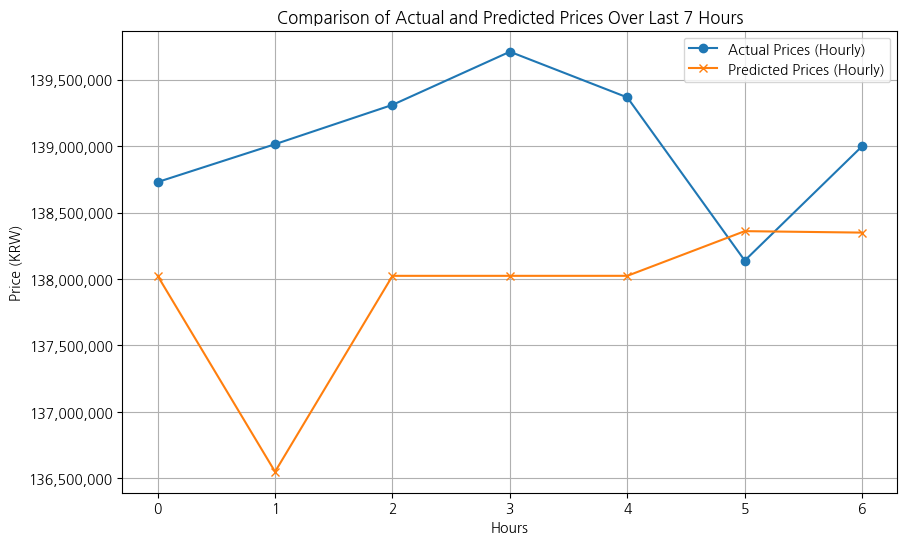

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 10단계: 지난 7시간 데이터와 예측값 비교
def compare_actual_and_predicted_hourly(model, X_price_test, X_sentiment_test, scaler, price_data):
    # 지난 7시간 실제 데이터 가져오기
    last_7_hours_actual = price_data['price'][-7:].values  # 최근 7시간의 실제 데이터

    # 모델로 지난 7시간 데이터 예측
    last_7_hours_predictions = []
    last_price_sequence = X_price_test[-8:-1]  # 최근 8개의 시간 단위 시퀀스 중 마지막 7개 사용
    last_sentiment_sequence = X_sentiment_test[-8:-1]

    for i in range(7):  # 7시간 예측
        predicted_price = model.predict([
            last_price_sequence[i].reshape(1, last_price_sequence.shape[1], 1),
            last_sentiment_sequence[i].reshape(1, last_sentiment_sequence.shape[1], 1)
        ])
        predicted_price_original = scaler.inverse_transform(predicted_price)[0][0]
        last_7_hours_predictions.append(predicted_price_original)

    # 그래프 출력
    plt.figure(figsize=(10, 6))
    plt.plot(range(7), last_7_hours_actual, label='Actual Prices (Hourly)', marker='o')
    plt.plot(range(7), last_7_hours_predictions, label='Predicted Prices (Hourly)', marker='x')
    plt.title('Comparison of Actual and Predicted Prices Over Last 7 Hours')
    plt.xlabel('Hours')
    plt.ylabel('Price (KRW)')

    # Y축 값에 쉼표 추가
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

    plt.legend()
    plt.grid()
    plt.show()

# 실행: 실제 데이터와 예측 비교 (시간 단위)
compare_actual_and_predicted_hourly(model, X_price_test, X_sentiment_test, scaler, price_data)
